In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from generate_data import generate_Ls, generate_sylvester_data
from proximal_gradient_descent import (
    get_optimizer_oracles,
    proximal_accelerated_gradient,
    project_to_lower_with_positive_diag,
    warm_start
)
from plotting_utilities import get_metrics, patternify_Ls, one_example_prs

# Prevent Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Verifying Strong Convexity

The algorithm has been designed to exhibit "linear convergence".  This is fast!  It means that if we want $K$ digits of precision, it should only take $O(K)$ steps of the algorithm to converge.

In [ ]:
np.random.seed(0)

# Let's generate a 50 x 50 matrix from our Cartesian LGAM model in which the
# ground truth graphs have only 10% nonzero elements.
dims = (50, 50)
sparsity = 0.1
Ls, L_patterns = generate_Ls(dims, sparsity=sparsity)
X = generate_sylvester_data(Ls, normalize=True, source_distribution=np.random.normal)

L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.5e-6
objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=5000,
    tol=1e-20
)

The above code will have fit the model.  Now, let's plot the change in the objective function over time.  Since this exhibits linear convergence, we should expect that this change looks linear on a logarithmic plot.  You can see that we quickly get to 10 digits of precision!

10 digits is about as good as we can do due to machine precision; note that we set the `tol` parameter, which governs when the algorithm stops, to 20 digits of precision ("`1e-20`"); the algorithm stopped at ("`1e-10`") because subsequent iterations became so small they got rounded to zero!

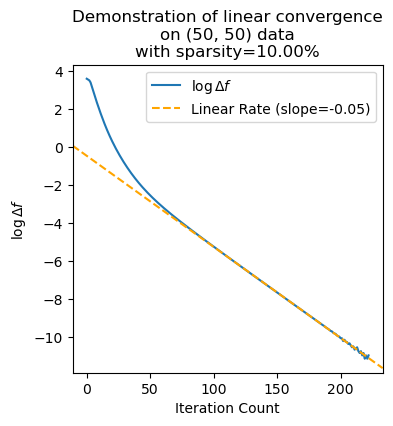

In [8]:
del_f = -np.array(eps)
iterations = np.arange(len(eps))

# Ignore iterations where the objective error increased
# (we use accelerated gradient descent so this will happen every now
# and then, which is annoying for taking the logarithm)
iterations = iterations[del_f > 0]
del_f = np.log10(del_f[del_f > 0])

# Fit a line through the data to demonstrate it really is linear
linear_data = iterations > 100
slope, intercept = np.polyfit(iterations[linear_data], del_f[linear_data], deg=1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(iterations, del_f, label=r"$\log\Delta f$")
ax.set_title(f"Demonstration of linear convergence\non {dims} data\nwith {sparsity=:.2%}")
ax.set_xlabel("Iteration Count")
ax.set_ylabel(rf"$\log\Delta f$")
ax.axline(xy1=(0, intercept), slope=slope, linestyle='--', color='orange', label=f'Linear Rate ({slope=:.2f})')
ax.legend()
pass

# PR Curves and F1/MCC

We can compare results on synthetic data (generated from the Cartesian LGAM model) using our algorithm and the standard LGAM model.  Since our model outputs two graphs, we have three variants of each metric - for example, we have an F1 score on the first graph, an F1 score on the second graph, and an F1 score for both graphs put together.

Note that, because the standard LGAM model assumes independence for one of the graphs (the first graph), its "combined score" will always be worse than ours because it is only learning one graph.  Thus it's not really a fair comparison.  Secondly, note that the graph that they both estimate (the second graph, "L2") is learned equally well by both algorithms.  This is a shame as we'd hope that our more complicated model does better.

Feel free to play with the sparsity pattern and problem size.  If you really wanted, take a peak into `generate_Ls` in `generate_data.py` and try generating different structures of data.  At the bottom of this notebook I demonstrate performance on an autoregressive process.

On my computer, the code below takes about one minute.

In [ ]:
np.random.seed(0)
dims = (50, 50)
sparsity = 0.1
Ls, L_patterns = generate_Ls(dims, sparsity=sparsity)
X = generate_sylvester_data(Ls, normalize=True)

L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoregs = np.logspace(0.2, -2, 50)
Lss, _ = warm_start(X, L_init, glassoregs=glassoregs)
Lss_lgam, _ = warm_start(X, L_init, glassoregs=glassoregs, sample_axes={0})

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:79: RuntimeWarning: invalid value encountered in divide
  precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(dims))]
/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:80: RuntimeWarning: invalid value encountered in divide
  shared_precs = shared_TPs / (shared_TPs + shared_FPs)
/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:86: RuntimeWarning: invalid value encountered in divide
  (TPs[i]*TNs[i] - FPs[i]*FNs[i])
/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:97: RuntimeWarning: invalid value encountered in divide
  (shared_TPs * shared_TNs - shared_FPs * shared_FNs)


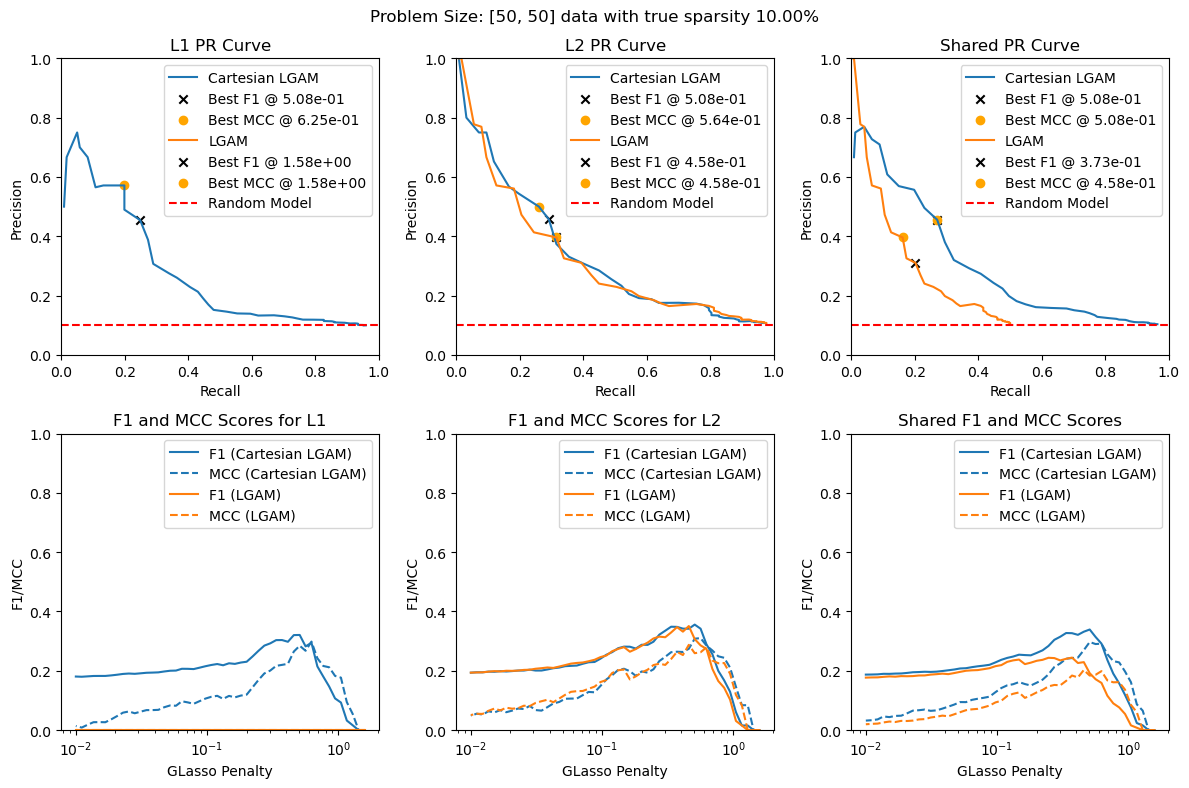

In [10]:
L_estim_patterns = patternify_Ls(Lss)
L_lgam_estim_patterns = patternify_Ls(Lss_lgam)

one_example_prs(
    L_patterns=L_patterns,
    Lss=Lss,
    Lss_lgam=Lss_lgam,
    glassoregs=glassoregs,
    sparsity=sparsity
)
pass

Below, we make the true graphs be AR(p), i.e. if we label nodes [1], [2], ... then [$i$] is connected to [$i\pm k$] for all $1\leq k \leq p$, and nothing else.

Feel free to mess with the $p$ parameter.  It does seem like there's a very slight improvement, but it's hard to know if it's real...

In [34]:
np.random.seed(1)
dims = (50, 50)
sparsity = 0.1
ar_p = 5
Ls = [np.eye(d) + np.triu(np.tril(np.random.randn(d, d), k=-1), k=-ar_p) / 2 for d in dims]
L_patterns = [np.abs(L - np.eye(L.shape[0])) > 1e-16 for L in Ls]

X = generate_sylvester_data(Ls, normalize=True)

L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoregs = np.logspace(0.2, -2, 50)
Lss, _ = warm_start(X, L_init, glassoregs=glassoregs)
Lss_lgam, _ = warm_start(X, L_init, glassoregs=glassoregs, sample_axes={0})

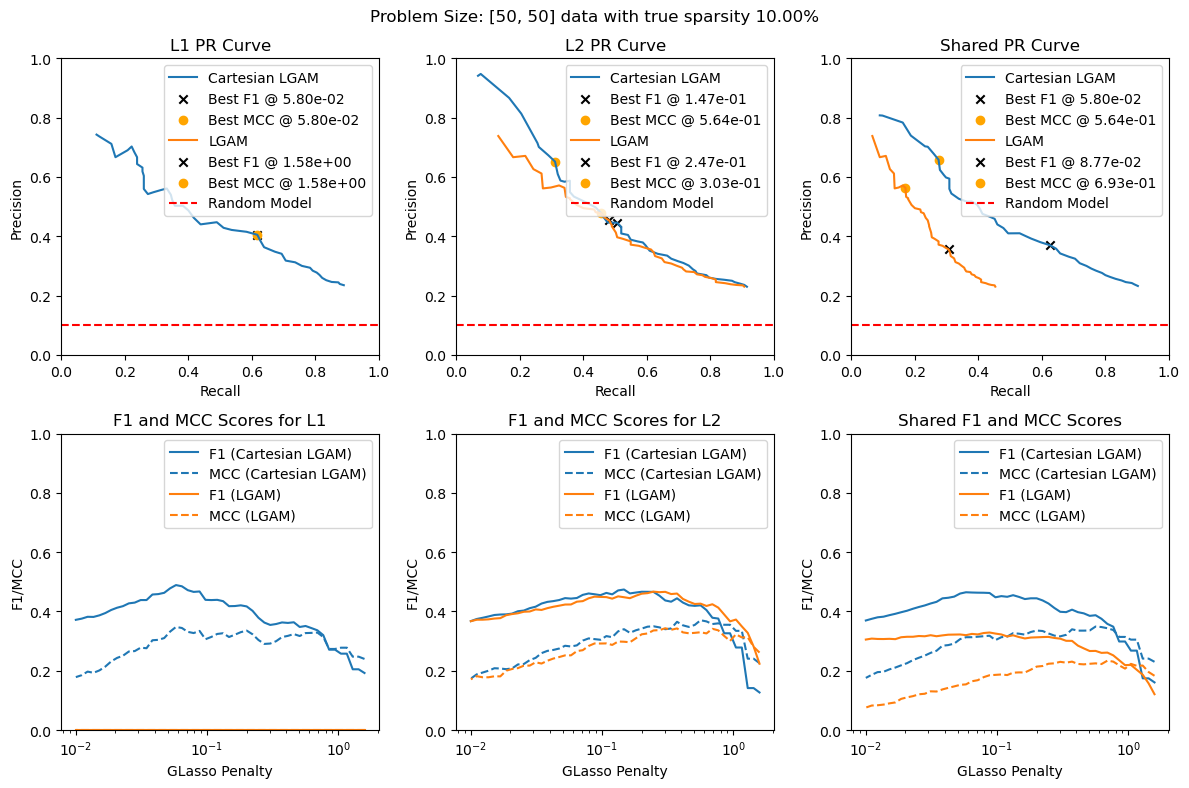

In [35]:
L_estim_patterns = patternify_Ls(Lss)
L_lgam_estim_patterns = patternify_Ls(Lss_lgam)

one_example_prs(
    L_patterns=L_patterns,
    Lss=Lss,
    Lss_lgam=Lss_lgam,
    glassoregs=glassoregs,
    sparsity=sparsity
)
pass

In [46]:
np.random.seed(10)
dims = (50, 50)
sparsity = 0.1
ar_p = 5
Ls = [np.eye(d) + np.triu(np.tril(np.random.randn(d, d), k=-1), k=-ar_p) / 2 for d in dims]
L_patterns = [np.abs(L - np.eye(L.shape[0])) > 1e-16 for L in Ls]

X = generate_sylvester_data(Ls, normalize=True)

L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoregs = np.logspace(0.2, -2, 50)
Lss, _ = warm_start(X, L_init, glassoregs=glassoregs)
Lss_lgam, _ = warm_start(X, L_init, glassoregs=glassoregs, sample_axes={0})

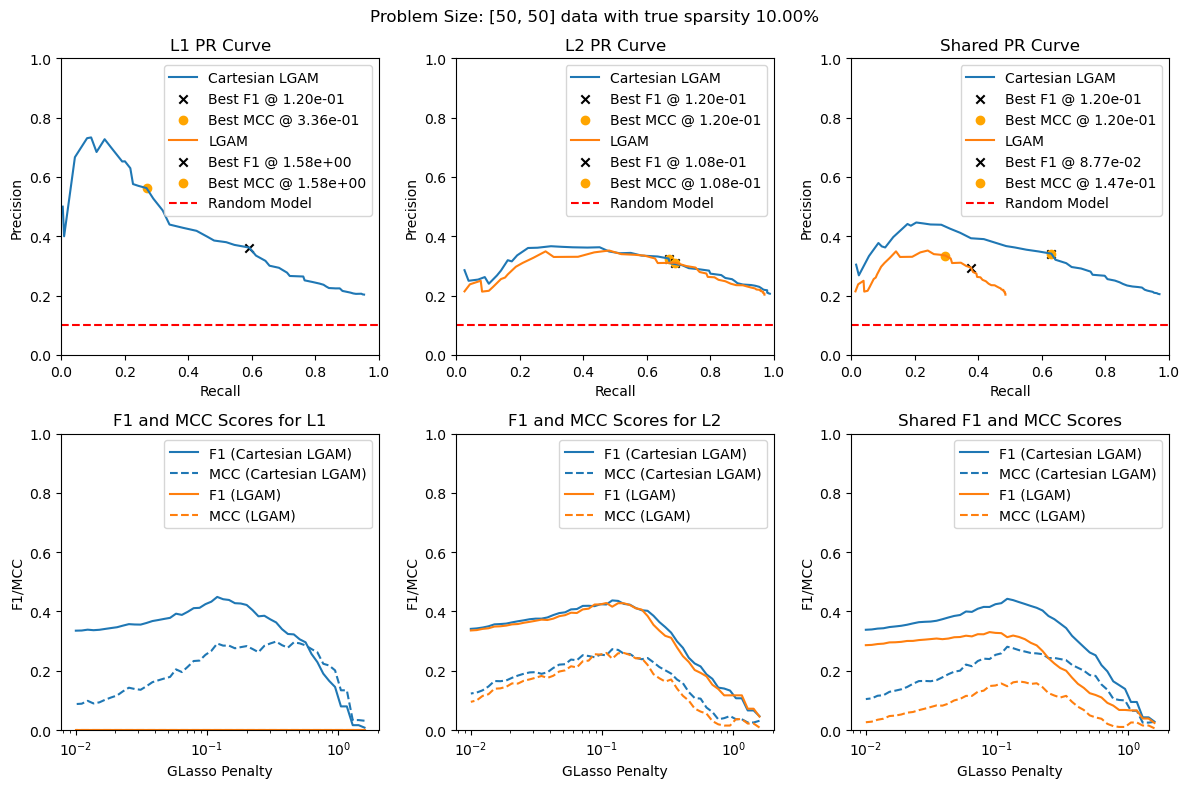

In [47]:
L_estim_patterns = patternify_Ls(Lss)
L_lgam_estim_patterns = patternify_Ls(Lss_lgam)

one_example_prs(
    L_patterns=L_patterns,
    Lss=Lss,
    Lss_lgam=Lss_lgam,
    glassoregs=glassoregs,
    sparsity=sparsity
)
pass

In [44]:
np.random.seed(10)
dims = (50, 50)
sparsity = 0.1
ar_p = 5
Ls = [np.eye(d) + np.triu(np.tril(np.random.randn(d, d), k=-1), k=-ar_p) / 2 for d in dims]
L_patterns = [np.abs(L - np.eye(L.shape[0])) > 1e-16 for L in Ls]

X = generate_sylvester_data(Ls, normalize=True).T

L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoregs = np.logspace(0.2, -2, 50)
Lss, _ = warm_start(X, L_init, glassoregs=glassoregs)
Lss_lgam, _ = warm_start(X, L_init, glassoregs=glassoregs, sample_axes={0})

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:79: RuntimeWarning: invalid value encountered in divide
  precs = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(dims))]
/Users/baileyandrew/Cartesian-LGAM/plotting_utilities.py:86: RuntimeWarning: invalid value encountered in divide
  (TPs[i]*TNs[i] - FPs[i]*FNs[i])


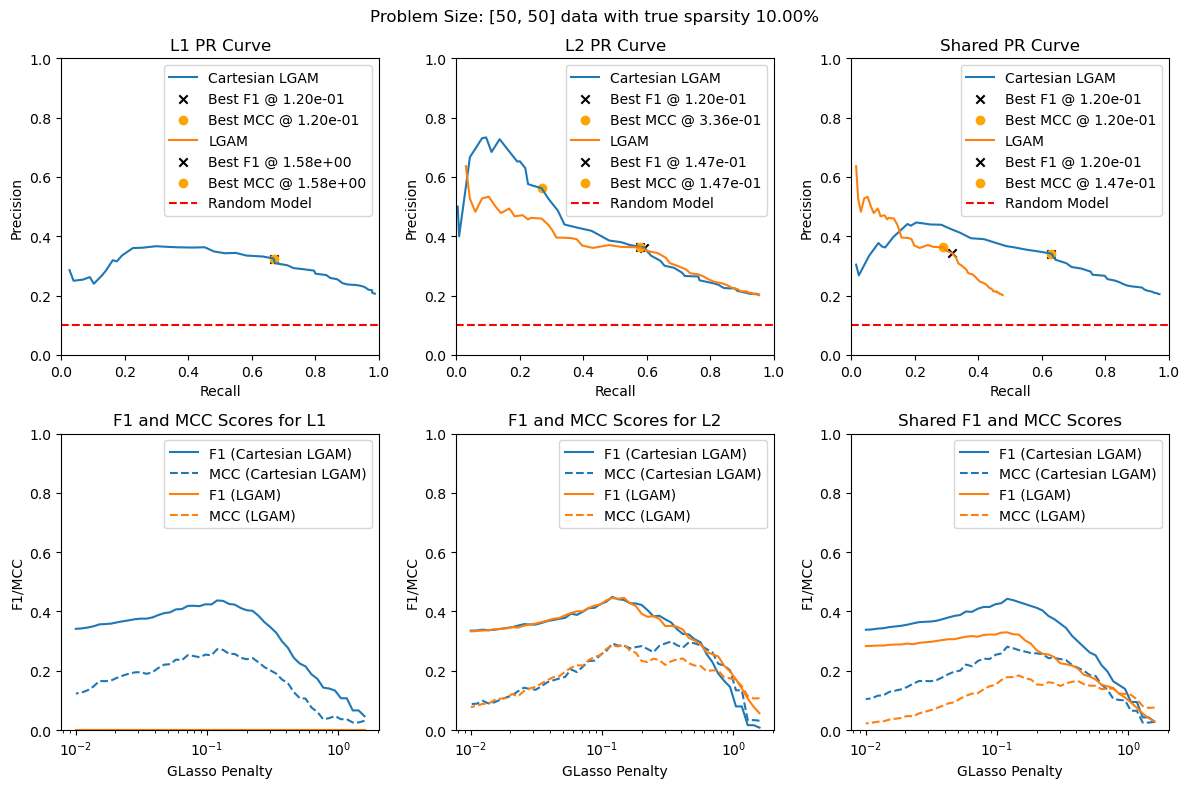

In [45]:
L_estim_patterns = patternify_Ls(Lss)
L_lgam_estim_patterns = patternify_Ls(Lss_lgam)

one_example_prs(
    L_patterns=L_patterns,
    Lss=Lss,
    Lss_lgam=Lss_lgam,
    glassoregs=glassoregs,
    sparsity=sparsity
)
pass